# Chinese Syllable Count Generator Working Draft Notes
*Designed, constructed, and documented by Jeff Heller, Data and Project Coordinator for the Department of East Asian Studies, Princeton University.*

*With expertise and assistance from fellow Princetonians:*

*Anna Shields, Professor of East Asian Studies*

*Joshua Seufert, Chinese Studies Librarian, The East Asian Library and the Gest Collection*

*Thomas Ventimiglia, Technical Support Specialist, The East Asian Library and the Gest Collection*

This document details the process of experimentation related to the construction of the Chinese Syllable Count Generator function. The function takes romanized Chinese text of any size or word count, evaluates the number of syllables based on the supplied Latin characters, and outputs a list of integers representing the syllables of each identified word.

The initial stages of development tests three methods of storing data for optimized processing comparison: Python list, NumPy Array, and Pandas DataFrame.

Structured systems are the basis of Chinese romanization with accepted combinations of "initials" (the initial sound of a syllable, e.g., the first consonant) and "finals" (the ending sound of a syllable, e.g., vowels that sometimes end with a consonant). For example, one syllable in pinyin can be as small as one letter and as large as six letters. Therefore, detecting a syllable can occur in one of two ways:
1. A sequence of letters compared to a list of accepted pinyin syllables. If the sequence appears in the list, or if the sequence is part of a longer accepted term ("tia" by itself is not an accepted syllable, however "tiao" and "tian" are), then an additional letter from the pinyin can be added to the sequence and reevaluated. If the sequence does not appear in the list and is not part of a longer accepted term, then the last character of the sequence becomes the first character of the next syllable, and the syllable count incremented.
2. A sequence of letters is processed incrementally with the initials identified first, and then the finals after the appearance of the first vowel. The identified initial and final values act as indexes to a table (either a NumPy Array or Pandas DataFrame) of boolean values that evaluate the initial and final pairing. If the table returns False, then the final is compared to a list of other final values to determine whether it can be part of a more extended final. If it is, then the function continues onto the next incremented letter. Otherwise, the function determines that the current letter is the start of the next syllable and increments the number of syllables for that word.

Given these possibilities, two metrics need to be considered to settle on the proper method for the evaluation function: speed and size. I hypothesize that comparing a sequence of letters to a list of terms can be faster; however, the list itself may be excessively large. Evaluating sequences by their combination of initials and finals, however, may take longer but results in a much smaller package. The following exercises test each method on a smaller scale to get a general sense of the speed vs. size issue.

## Setup for Testing

The code below imports two CSV files. The first contains the list of acceptable pinyin syllables (e.g. "yang," "wei"). The second contains an array of 1 values with a column header of initials and row headers with finals. Empty values convert to 0, and both 1 and 0 values convert to the boolean values True and False, respectively in their array and DataFrame forms.

In [112]:
import csv
import sys

import numpy as np
import pandas as pd

## LIST ##
# Import list of all pinyin combinations
smList = []
with open("data/pinyinList.csv") as f:
    r = csv.reader(f)
    for row in r:
        smList += row

## NUMPY/DATAFRAME ##
# List of initials, finals for Numpy evaluation
PY = np.genfromtxt("data/pinyinDF.csv", delimiter=",", dtype=str)
initList = list(PY[1:, 0])
finList = list(PY[0, 1:])

# Import Numpy array from CSV
smAr = PY[1:, 1:] == "1"

# Import dataframe from CSV
smDF = (
    pd.read_csv("data/pinyinDF.csv", header=0,
                index_col=0, dtype={"INDEX": str})
    .fillna(0)
    .astype("bool")
)

# Print examples of each form of reference data.
print("Python List:")
print(str(smList[0:30]))
print("Displaying 30 of " + str(len(smList)) +
      " possible pinyin combinations " + "\n")
print("——————————————————\n")
print("# Header lists for use in indexing the array/DataFrame")
print("Initials List:")
print(initList)
print("Finals List:")
print(str(finList) + "\n")
print("——————————————————\n")
print("Numpy Array:")
print(str(smAr[0]))
print("Displaying 1 of " + str(len(smAr)) + " rows within the array" + "\n")
print("Pandas DataFrame:")
print(smDF.head(3))


Python List:
['a', 'ai', 'ao', 'an', 'ang', 'e', 'ei', 'en', 'eng', 'er', 'o', 'ou', 'yi', 'ya', 'yao', 'ye', 'you', 'yan', 'yang', 'yin', 'ying', 'yong', 'wu', 'wa', 'wo', 'wei', 'wai', 'wan', 'wen', 'wang']
Displaying 30 of 407 possible pinyin combinations 

——————————————————

# Header lists for use in indexing the array/DataFrame
Initials List:
['ø', 'b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'z', 'c', 's', 'zh', 'ch', 'sh', 'r', 'j', 'q', 'x', 'g', 'k', 'h', 'y', 'w']
Finals List:
['a', 'ai', 'ao', 'an', 'ang', 'e', 'ei', 'en', 'eng', 'er', 'o', 'ong', 'ou', 'i', 'ia', 'iao', 'ie', 'iu', 'ian', 'iang', 'in', 'ing', 'iong', 'u', 'ua', 'uo', 'ue', 'ui', 'uai', 'uan', 'uang', 'un', 'v', 've']

——————————————————

Numpy Array:
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False False False False False False False False False False
 False False False False False False False False False False]
Displaying 1 of 24 rows within the array

Pandas DataFram

## Performing the Tests
To best compare the size and performance speed of each method this test works with two examples: a small two-letter phrase that is an acceptable pinyin term ("ba"), and a longer five-letter term that is not an acceptable pinyin term ("quang"). The %timeit function measures processing time with each method after running 100,000 iterations.

### Methods
1. The Python "in" function: the script searches through the list of acceptable pinyin terms for the supplied example.
2. The examples split into their initial and final pairs, their indexes derived from within the list of initials and finals, and those values are then used to find the appropriate boolean within the NumPy Array.
3. A Pandas DataFrame houses the boolean values, and three Pandas-specific methods are used to slice it:
    1. Traditional slicing method (to be deprecated in future versions): "exampleDF[initial][final]"
    2. The .loc method: "exampleDF.loc[initial][final]"
    3. The .iloc method: "exampleDF.iloc[index of initial within list of initials][index of final within list of finals]"

In [58]:
# Variables used for testing
smEval1 = "ba"
smInitial1 = "b"
smFinal1 = "a"

smEval2 = "quang"
smInitial2 = "q"
smFinal2 = "uang"


# Subject 1: Short, acceptable term
print('# Results of "ba" (short, valid):')

# Method 1: Python List
print("Python List: " + str(sys.getsizeof(smList)))
%timeit -n 100000 smEval1 in smList

# Method 2: Numpy Array
print(
    "\nNumpy array: "
    + str(sys.getsizeof(initList) + sys.getsizeof(finList) + sys.getsizeof(smAr))
    + ", without initials and finals lists: "
    + str(sys.getsizeof(smAr))
)
%timeit -n 100000 smAr[initList.index(smInitial1), finList.index(smFinal1)] != True

# Method 3: Pandas DataFrame
# 3a: slice
print("\nDataFrame: " + str(sys.getsizeof(smDF)))
print("slice")
%timeit -n 100000 smDF[smFinal1][smInitial1] != True

# 3b: loc
print("loc")
%timeit -n 100000 smDF.loc[smInitial1, smFinal1] != True

print("iloc")
# 3c: iloc
%timeit -n 100000 smDF.iloc[initList.index(smInitial1), finList.index(smFinal1)] != True


# Subject 2: Longer, unacceptable term
print('\n\n# Results of "quang" (longer, invalid):')

# Method 1: Python List
print("Python List: " + str(sys.getsizeof(smList)))
%timeit -n 100000 smEval2 in smList

# Method 2: Numpy Array
print(
    "\nNumpy array: "
    + str(sys.getsizeof(initList) + sys.getsizeof(finList) + sys.getsizeof(smAr))
    + ", without initials and finals lists: "
    + str(sys.getsizeof(smAr))
)
%timeit -n 100000 smAr[initList.index(smInitial2), finList.index(smFinal2)] != True

# Method 3: Pandas DataFrame
# 3a: slice
print("\nDataFrame: " + str(sys.getsizeof(smDF)))
print("slice")
%timeit -n 100000 smDF[smFinal2][smInitial2] != True

# 3b: loc
print("loc")
%timeit -n 100000 smDF.loc[smInitial2, smFinal2] != True

print("iloc")
# 3c: iloc
%timeit -n 100000 smDF.iloc[initList.index(smInitial2), finList.index(smFinal2)] != True

# Results of "ba" (short, valid):
Python List: 3760
438 ns ± 24.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numpy array: 1672, without initials and finals lists: 928
1.38 µs ± 39.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

DataFrame: 2427
slice
10.1 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
loc
8.04 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
iloc
8.9 µs ± 32.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Results of "quang" (longer, invalid):
Python List: 3760
4.02 µs ± 49.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numpy array: 1672, without initials and finals lists: 928
1.94 µs ± 24.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

DataFrame: 3067
slice
10.1 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
loc
7.98 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
iloc
9.77 µs ± 132 ns per loop (mean ± std

## Comparison: Size
The Pandas DataFrame would initially be the smallest form of a boolean table (2.427kb). However, it becomes 25% larger when reaccessed for multiple inquiries due to being loaded into its self-maintained cache (3.067kb). The NumPy array, in addition to the necessary initials and finals lists, takes more space than the initial size of the DataFrame but maintains a small size after repeated uses (2.6kb). The Python list, as expected, takes up the most amount of space due to its listing every possible syllable (3.76kb). Therefore, the NumPy array is the best option assuming the function evaluates multiple queries.

## Comparison: Speed
As expected, there is little difference in speed between the NumPy array evaluating the smaller, acceptable syllable and the larger, unacceptable syllable, with only a 0.55-microsecond difference between them. The Pandas DataFrame performed just as consistently, with an average of a 0.28-microsecond difference between the smaller and larger syllables. However, the DataFrame speed as a whole was impractically slower, with an average of 8.17 microseconds per 100,000 iterations, compared to 1.51 microseconds for the NumPy array.

The Python list resulted in the most significant disparity in time with a 3.28-microsecond difference between the smaller and larger syllables. However, the incredibly quick .399 microsecond result for the smaller, acceptable phrase initially made the option the most attractive for use. Having to search an entire list when supplied an invalid syllable is the disadvantage, leading to its 3.68-microsecond result. Future calculations finding the average length of syllables in practical Chinese use could dictate the real average time of the Python list option, but—assuming that the statistical mean suffices for optimizing this function—the 2.04-microsecond average does not beat that of the NumPy array. Therefore, the array is the best method for this function.

# The sylCount function
With the NumPy array chosen as the index method for acceptable vs. unacceptable syllables, the sylCount function evaluates the inputted text character-by-character. Computational processes benefit from the consistent syllable structure of the Chinese language because—with very few exceptions—most syllables begin with consonants as their initial and vowels as their final (e.g. "chou:" "ch" as initial, "ou" as final). Therefore, an automated process can quickly establish the initial until it encounters a vowel, accessing the array afterward to determine whether the combination of initial and final is valid.

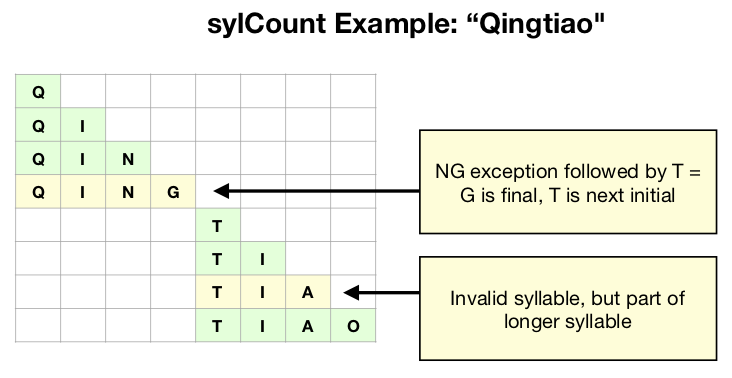

In [1]:
from IPython.display import Image
Image('img/EvaluationExample.png', width=400)

The validity of syllables is an essential step in the function because not only will it determine whether the current sequence of letters counts as a syllable, but also if the syllable is still valid with additional letters added to it. For example, "tiao." The character-by-character loop within the function sets the initial to "t," and then on its next iteration identifies "i" as the final. "Ti," in itself, is a valid syllable. However, the following character "a" results in "tia," which is not a valid syllable. Searching the array is crucial at this stage because "tiao" is an acceptable syllable, but only if detected during the "tia" evaluation. If no other possibilities exist when evaluating a sequence, then it is safe to assume the current syllable has ended.

There are exceptions to this rule, specifically with the possibility of consonants appearing in the final, e.g., "qing." In the pinyin standard, "n," "ng," and "r" (only after following an "e") are all possible consonants in the final. The function, accordingly, must include the ability to evaluate these occurrences and assess whether they are finals, initials, or a combination of both in the case of "ng." Thankfully, these occurrences can be broken down into consistent patterns that are easy to translate into Python.

## The *n* logic
The tables below illustrate the logic behind the evaluation of *n*. Because *n* can appear as initial or final, the first and most straightforward approach to identifying its pattern is to look at each possible scenario for any character in pinyin. One character can have nine total possibilities in its placement, depending on whether there is a vowel, consonant, or nothing preceding it, and a vowel, consonant or nothing succeeding it. According to the table, *n* is only an exception when there is a vowel preceding or succeeding it. All other possibilities are grammatically erroneous, especially if there is a preceding consonant.

In [28]:
from IPython.display import HTML, display
display(HTML("<table style='background-color:black;'><tr><td><img src='img/pinyinPairs.005.png'></td><td><img src='img/pinyinPairs.006.png'></td></tr></table>"))

,


These tables also indicate how the function processes valid possibilities. In the case of *n* with a preceding and succeeding vowel, the syllable count increments by one to account for it being the start of the next syllable. Identifying the character as initial or final is crucial for the function to evaluate the next character correctly.

## The *ng* logic

In [41]:
from IPython.display import HTML, display
display(HTML("<table style='background-color:black;'><tr><td><img src='img/pinyinPairs.003.png'></td><td><img src='img/pinyinPairs.004.png'></td></tr></table>"))

,


For *ng*, the logic is more explicit. The function only identifies the ng pair if there is a preceding vowel since all other possibilities are grammatically incorrect. Also, because *g* is assumed to be the current character in evaluation, the function can quickly identify whether it is the initial of a new syllable or the end of the final based on whether a vowel succeeds it.

## The *er* logic

In [42]:
from IPython.display import HTML, display
display(HTML("<table style='background-color:black;'><tr><td><img src='img/pinyinPairs.001.png'></td><td><img src='img/pinyinPairs.002.png'></td></tr></table>"))

,


The *er* pair has much greater complexity because all nine possibilities are grammatically correct. However, patterns emerge when analyzing their usage in pinyin. If er precedes any character, then the syllable count increments by one to account for the additional syllable. The count also increments by one if er—preceded by a vowel—is succeeded by anything except a vowel. Identifying the current character *r* as initial or final is a simple matter of evaluating whether the succeeding character is a vowel or not.

# The Code

## Initial Setup

### 1. Package Dependencies
Import necessary packages for function

In [4]:
import numpy as np
import csv
import re

### 2. Reference Data
List of pinyin initials, finals for Numpy evaluation

In [5]:
PY = np.genfromtxt('data/pinyinDF.csv', delimiter=',', dtype=str)
initPYList = list(PY[1:, 0])
finPYList = list(PY[0, 1:])

# List of Wade-Giles initials, finals
WG = np.genfromtxt('data/wadegilesDF.csv', delimiter=',', dtype=str)
initWGList = list(WG[1:, 0])
finWGList = list(WG[0, 1:])

# Import Numpy arrays from CSV
arPY = PY[1:, 1:] == '1'
arWG = WG[1:, 1:] == '1'

### 3. Reference Variables
Lists/array for reference for easy editing and upgrading

In [6]:
vowel = ['a', 'e', 'i', 'o',
         'u', 'ü', 'v', 'ê', 'ŭ']  # for detecting switch from initial to final

replSym = {'—': '-',
           '–': '-',
           '\'': '’',
           '\u3000': ' '}  # for replacing known invalid characters

### 4. Helper Functions

In [7]:
# 4a. Lists/array for text evaluation
def set_dictionary(wg, crumbs):
    '''Initialize array variables for syllable lookup.'''
    if not wg:
        crumbs_report(crumbs, 'Pinyin system loaded')
        return initPYList, finPYList, arPY
    else:
        crumbs_report(crumbs, 'Wade-Giles system loaded')
        return initWGList, finWGList, arWG

# 4b. Off-loaded, common processes
def crumbs_report(crumbs, status):
    '''Report analyzation steps to the user.'''
    if crumbs:
        print(status)
        
def error_report(errorReport, errorMsg):
    '''Return error messages during analyzation process.'''
    if errorReport:
        return errorMsg
    else:
        return [0]

### 5. Validation Functions

In [8]:
# 5a. Individual validation steps
def CBDB_check(text, CBDB):
    '''CBDB testing purposes ONLY: if the family name is duplicated in the given name'''
    if CBDB and len(text.split()) > 1:
        dupTest = text.split()
        dupTestLen = [len(dupTest[0]), len(dupTest[1])]
        # If the beginning of the given name appears in the family name...
        return (dupTest[0] == dupTest[1][0:dupTestLen[0]] and
            # ...and the given name is longer than the family name (not equal or less)...
            dupTestLen[1] > dupTestLen[0] and
            # ...and it's not just an apostrophe (Wen Wen’chang)...
            dupTest[1][len(dupTest[0])] != "’")
            # ...then the family name has been duplicated
    
def invalid_chars(text):
    '''Check for invalid characters after known invalid characters have been replaced.'''
    evalText = text
    for i, n in replSym.items():
        evalText = evalText.replace(n, '')
    return evalText.isalpha()

def replace_chars(text):
    '''Replace known invalid characters for standardization.'''
    text = text.strip().lower()
    for i, n in replSym.items():
        text = text.replace(i, n)
        re.sub(r'\s{2,}', ' ', text)
    return text
    
# 5b. Main validation function
def validate_text(text, CBDB):
    '''Run text through initial steps to prevent evaluation errors.'''
    result = [text]
    try:
        result[0] = replace_chars(text)
    except:
        return result.append('Error: null value')
    if not invalid_chars(text):
        return result.append('Error: invalid characters detected (' + text + ')')
    if CBDB_check(text, CBDB):
        return result.append('Error: duplicate family name in given name')
    return result

## The Main Function

### 1. Special Characters (e.g., hyphen, apostrophe, spaces)

In [9]:
def special_characters(n, initial, final):
    '''Accessed when current character is non-alpha.'''
    notes = '[new '
    if n == ' ':
        notes += 'word] space'
    else:
        notes += 'syl] '
        if n == '-':
            notes += 'hyphen'
        elif not wg and n == '’':
            notes = 'pinyin apostrophe'
    newSyl = True
    return newSyl, notes, initial, final, errorMsg

### 2. Finals

In [70]:
def final_evaluation(text, i, n, initial, final, initList, finList, ar, wg, newSyl):
    ''''''
    errorMsg = ''
    notes = '[fin] '

    # If 'er,' 'ng,' or 'n'
    if (final[-1] == 'e' and n == 'r' or
          final[-1] == 'n'):
        notes = final[-1] + n

        # If there are more characters ahead, mark as new syllable
        if i != len(text) - 1 and text[i+1] != ' ' and text[i+1] != '-':
            newSyl = True
            exFin = final[-1] + n
            notes += ' - not \"' + exFin + '\" final'

        # Else if there were other vowels before 'er,' add a syllable
        elif (notes == 'er' and len(final) > 1) or n in vowel:
            syl += 1
            notes += ' - extra syl at end'

    # Check array with current initial + final combo
    else:

        # If there's an error, consider it as not a valid syllable
        try:
            result = ar[
                initList.index(initial),
                finList.index(final + n)
            ]
            notes += (' - array lookup ' + initial + final + n +
                      ': ' + str(result))
        except:
            result = False
            notes += ' - array error'

        # If not a valid syllable, is it part of a longer syllable?
        if not result:
            try:
                listFins = list(
                    i for i in finList if i.startswith(final+n))
                arbool = not listFins or not any(
                    i for i in listFins if ar[
                        initList.index(initial),
                        finList.index(i)
                    ]
                )

            except:
                errorMsg = ('Error: ' + initial + final + n +
                            ' - quitting, invalid initial/final pair')
            else:
                if arbool:  # It isn't!
                    try:
                        nextChar = text[i+1]
                    except:
                        errorMsg = ' - end of word and no match'
                    else:
                        newSyl = True
                        notes += ' - new syl'
                else:  # It is.
                    final += n
                    notes += ' - definitely more'

        # Otherwise, the syllable is valid
        else:
            final += n
            notes += ' - maybe more'
            
    return newSyl, notes, initial, final, errorMsg

### 3. Initials

In [71]:
def initial_evaluation(n, initial, final, initList):
    '''Identify character as an initial or final when no final is currently set.'''
    newSyl = False
    errorMsg = ''
    notes = '[init] '
    
    # If character is not a vowel
    if n not in vowel:

        # Check if character is, or is part of, a valid initial
        if not any(i for i in initList if i.startswith(initial + n)):
            errorMsg = ('Error: ' + initial + n +
                        ' - quitting, invalid initial')
        initial += n
        notes += 'consonant'

    # Then the vowel is the first character of the final if there's no initial
    else:
        if not initial:
            initial = 'ø'
            notes += 'null initial'
        else:
            notes += 'vowel'
        final = n

    return newSyl, notes, initial, final, errorMsg

In [72]:
# sylCount definition with parameters:
# crumbs: show breadcrumbs of NumPy evaluation
# errorReport: return error messages as strings, NaN for non-errors
# CBDB: detect duplication of family name within given name
# wg: evaluate in Wade-Giles standard


def sylCount(text, crumbs=False, errorReport=False, CBDB=False,
             wg=False, method=False, itr=''):
    '''Return the number of Chinese characters based on inputted romanized text
    (amongst other things).'''
    
    initList, finList, ar = set_dictionary(wg, crumbs)

    validationResult = validate_text(text, CBDB)
        
    if len(validationResult) > 1:
        crumbs_report(crumbs, errorMsg)
        return error_report(errorReport, errorMsg)
    else:
        text = validationResult[0]


    ## MAIN EVALUATION VARIABLES ##
    # Variables used for evaluation
    initial = ''
    final = ''
    syl = 1
    sylAdd = []
    exFin = ''

    crumbs_report(crumbs, '# Testing ' + text + ' #')

    ## MAIN EVALUATION ##
    # Cycle through each character in text
    for i, n in enumerate(text):

        ## SPECIAL CHARACTERS ##
        if not n.isalpha() and (wg and not n == '’'):
            charResult = special_characters(n, initial, final)
            crumbStep = '0. '

        ## FINALS ##
        # If final has already been set, regardless of current character
        elif final:
            charResult = final_evaluation(text, i, n, initial, final, initList, finList, ar, wg, newSyl)
            crumbStep = '1. '

        ## INITIALS ##
        # If there is no final set (then must be initial)
        else:
            charResult = initial_evaluation(n, initial, final, initList)
            crumbStep = '2. '
        
        newSyl, notes, initial, final, errorMsg = charResult

        ## ERROR ENCOUNTERED ##
        if errorMsg:
            crumbs_report(crumbs, errorMsg)
            if itr:
                return error_report(errorReport, errorMsg)
            else:
                wg = not wg
                return sylCount(text, crumbs, errorReport, CBDB,
                                wg, method, itr = initial + n + '/')
        
        ## DEBUG NOTES ##
        # Printed if crumbs parameter is true
        crumbStep += initial + '|' + final + ' ' + notes 
        crumbs_report(crumbs, crumbStep)

        ## NEW SYLLABLE ##
        # Set up next initial and/or final based on prior evaluation above
        if newSyl:

            # If current letter is a vowel
            if n in vowel:

                # If final was being evaluated for 'n' (e.g. 'ch|iN-A|ng')
                if exFin:
                    initial = 'n'

                # Otherwise it's simply a new syllable (e.g. 'ch|eng-A|ng')
                else:
                    initial = 'ø'
                syl += 1
                final = n

            # Or it's anything but a space (consonant, hyphen, apostrophe)
            elif n != ' ':

                # If character is break symbol or next character is next syllable
                if (
                    (exFin and text[i+1] not in vowel) or
                    (n == '’' or n == '-')
                ):
                    initial = ''

                    # If it's the 'er' situation with a vowel before it
                    if exFin == 'er' and len(final) > 1:
                        syl += 1

                # Then current character is the start of next syllable
                else:
                    initial = n
                    
                exFin = False
                final = ''
                syl += 1

            # Then it is a space (new word)
            else:
                initial = ''
                final = ''
                syl = 1
            crumbs_report(crumbs, 'new syl: ' + str(syl))
            newSyl = False

    # Append syllable count to list after end of text evaulation
    sylAdd.append(syl)

    # Return a null value if the errorReport parameter is true
    error_report(errorReport, np.nan)

    # Return the romanization method if the method parameter is true
    if method:
        if wg:
            return 'Wade-Giles'
        else:
            return 'Pinyin'

    # Otherwise return the list of syllable counts
    else:
        return sylAdd


In [73]:
sylCount('shih', crumbs=True, errorReport=True)

Pinyin system loaded
# Testing shih #
2. s| [init] consonant
2. sh| [init] consonant
2. sh|i [init] vowel
 - end of word and no match
Wade-Giles system loaded
# Testing shih #
2. s| [init] consonant
2. sh| [init] consonant
2. sh|i [init] vowel
1. sh|ih [fin]  - array lookup shih: True - maybe more


[1]

# Case Study 1: Tang History Database
The Tang History Database, initiated by East Asian Studies Professor Anna Shields and designed by Data and Project Coordinator Jeff Heller, is a comparative database that allows scholars to visualize and analyze information from the Tang Dynastic History written by the Later Jin dynasty in 945AD and the version published by the Song dynasty in 1044AD. The project provides textual analysis tools such as dynamic search capabilities and a social network of Tang dynasty nobles and political figures. A challenge in preparing the data for this work was adequately tagging the names of figures within biographies. By doing this, we could better understand the relationship between Tang dynasty figures and how the text represents them, as well as the commonality of specific names used for a particular person, including instances where a person's biography mentions their name multiple times in various ways.

With Latin-based languages we separate a person's given name (first name) from their family name (last name) with the space character (" "), and from a computational standpoint essential for fast discovery of given names throughout the text (e.g., "This is **Jeff Heller's** biography. **Jeff** was born on..."). The Chinese language, however, does not provide a method of separation between names which is much harder to process computationally, especially if a name can also be a colloquial term (in English this occurs with names like "Summer" or "Shields"). Therefore, finding all occurrences of a person by their given name within their biography requires a customized method to identify it first. Harvard University's Chinese Biographical Database Project ([CBDB](https://projects.iq.harvard.edu/cbdb/home)) is an essential tool for this situation because it contains names in both the original Chinese and their pinyin counterpart.

The sylCount function was first used to deliver the list of syllables for each name. 

In [74]:
# Import necessary packages
import pandas as pd

# Import name data from Tang History Database to be split
names = pd.read_csv('data/TangHistoryNames.csv', index_col=0,
                    names=['EngName', 'ChiName'])

# Convert ideographic spaces to regular spaces, then remove all spaces.
names['ChiName'] = names['ChiName'].str.replace('\u3000', ' ').replace(' ', '')

# Run sylCount function and return results to 'syl' column
names['syl'] = names['EngName'].apply(sylCount)

Another custom function, nameSplit, was designed to take the list of syllable counts and apply them to the Chinese text, returning a list of separated names. The custom function included safeguards for invalid Chinese names (those with paragraph symbols or other extraneous characters, for example) and single names. The resulting list was then exported and implemented into the database, which now houses both family and given names for each figure.

In [80]:
# Define nameSplit function to facilitate separation of family name from given name
def nameSplit(chiName, syls, select=False):
    '''Separate Chinese characters based on supplied list of syllable counts'''

    if len(syls) < 2: # If there is only one syllable for a given name (no splitting needed)
        if syls == [0]:
            return None # Errors found in sylCount process result in null values
        else:
            return chiName # Single names are returned
    else:
        names = []

    if select: # If select parameter has a value above 0, return whichever name is specified
        cut = sum(syls[:select-1])
        names = chiName[cut:cut+syls[select-1]]

    else: # Otherwise, separate each Chinese phrase into a list
        for i, n in enumerate(syls):
            cut = sum(syls[:i])
            names.append(chiName[cut:cut+n])

    return names


# Apply the function to each row and return results to 'names' column
names['names'] = names.apply(lambda x: nameSplit(x['ChiName'], x['syl']), axis=1)

# Display 20 random rows
display(names.sample(n=20))

,EngName,ChiName,syl,names
92833,Du Zhisong,杜之松,"[1, 2]","[杜, 之松]"
196078,Lai Tian,來瑱,"[1, 1]","[來, 瑱]"
184577,Jiang Xi,蔣係,"[1, 1]","[蔣, 係]"
26934,Yao Yi(2),姚懿,[0],None
31790,Liu Shi(3),柳奭,[0],None
31152,Wei E,韋諤,"[1, 1]","[韋, 諤]"
180228,Xue Bo,薛播,"[1, 1]","[薛, 播]"
184316,Cheng Yi,程异,"[1, 1]","[程, 异]"
22451,Han Xiu,韓休,"[1, 1]","[韓, 休]"
33158,Zheng Huan,鄭澣,"[1, 1]","[鄭, 澣]"


In [40]:
import pandas as pd

names = pd.read_csv('data/allCBDBnames.csv', index_col=0,
                    names=['EngName', 'ChiName'], header=0)

names['ChiName'] = names['ChiName'].str.replace('\u3000', ' ').replace(' ', '')

names['syl'] = names['EngName'].apply(sylCount)

names['errors'] = names['EngName'].apply(sylCount, CBDB=True,
                                         errorReport=True).fillna('')

names['method'] = names['EngName'].apply(sylCount, method=True)


def tryAdd(x):
    try:
        return sum(x)
    except:
        return


names['check'] = names['ChiName'].str.len() == names['syl'].apply(tryAdd)
display(names.sample(n=20))

,EngName,ChiName,syl,errors,method,check
89750,Han Yu,韓瑜,"[1, 1]",,Pinyin,True
47015,Qiu Shi(Wife of Zhang Cun ),仇氏(張存妻),[0],Error: invalid characters (qiushi(wifeofzhangc...,[0],False
30912,Sima De,司馬德,"[2, 1]",,Pinyin,True
152024,Zhao Shi(Wife of Mengjun),趙氏(孟俊妻),[0],Error: invalid characters (zhaoshi(wifeofmengj...,[0],False
389058,He Yutan,何裕壇,"[1, 2]",,Pinyin,True
69441,Wang Wandai,王萬岱,"[1, 2]",,Pinyin,True
350803,Zhu Yi,朱儀,"[1, 1]",,Pinyin,True
328484,Zhao Cong,趙琮,"[1, 1]",,Pinyin,True
135130,He Yuxian,何玉仙,"[1, 1, 2]",,Pinyin,False
168362,Du Gongzhi,杜公制,"[1, 2]",,Pinyin,True


In [72]:
names[~names.check][~names.errors.str.contains('\(')][~names.ChiName.str.contains('\(')][~names.errors.str.contains('duplicate')].sample(n=50)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,EngName,ChiName,syl,errors,method,check
92583,Shi Zizai,釋自在,"[1, 1, 2]",,Pinyin,False
443274,Cong Gong,叢貢,"[1, 1]",,Pinyin,False
22595,Hong Fu,洪,"[1, 1]",,Pinyin,False
217100,Song 隲,宋隲,[0],"Error: ng - quitting, invalid initial",[0],False
272860,Song Yuang,宋宇昂,"[1, 1]",,Pinyin,False
145117,Yao,姚囗,[1],,Pinyin,False
94260,Shi Yuanzhao,釋圓照,"[1, 1, 2]",,Pinyin,False
122738,Li Yuniang,黎瑜孃,"[1, 1, 2]",,Pinyin,False
339779,Aixinjueluo Zaitian,載湉,"[4, 2]",,Pinyin,False
94295,Xu Diaozhe,徐釣者,"[1, 1, 2]",,Pinyin,False


In [101]:
sylCount('Ch\'üan-chou shih', crumbs=True)

Pinyin system loaded
# Testing ch’üan-chou shih #
a. c: init - cons
a. ch: init - cons
Error: ch’ - quitting, invalid initial
Wade-Giles system loaded
# Testing ch’üan-chou shih #
a. c: init - cons
a. ch: init - cons
a. ch’: init - cons
a. ch’ü: init - vowel
b. ch’|üa: fin - array error - definitely more
b. ch’|üan: fin - array lookup ch’üan: True - maybe more
0. new syl: hyphen
new syl: 2
a. c: init - cons
a. ch: init - cons
a. cho: init - vowel
b. ch|ou: fin - array lookup chou: True - maybe more
0. new word: space
new syl: 1
a. s: init - cons
a. sh: init - cons
a. shi: init - vowel
b. sh|ih: fin - array lookup shih: True - maybe more


[2, 1]

In [100]:
sylCount('aixinjueluo fufong', crumbs=True)

Pinyin system loaded
# Testing aixinjueluo fufong #
a. a: init - starting vowel
b. ø|ai: fin - array lookup øai: True - maybe more
b. ø|aix: fin - array error - new syl
new syl: 2
a. xi: init - vowel
b. x|in: fin - array lookup xin: True - maybe more
b. x|inj: nj - not "nj" final
new syl: 3
a. ju: init - vowel
b. j|ue: fin - array lookup jue: True - maybe more
b. j|uel: fin - array error - new syl
new syl: 4
a. lu: init - vowel
b. l|uo: fin - array lookup luo: True - maybe more
0. new word: space
new syl: 1
a. f: init - cons
a. fu: init - vowel
b. f|uf: fin - array error - new syl
new syl: 2
a. fo: init - vowel
b. f|on: fin - array error - new syl
new syl: 3
Error: ng - quitting, invalid initial
Wade-Giles system loaded
# Testing aixinjueluo fufong #
a. a: init - starting vowel
b. ø|ai: fin - array lookup øai: True - maybe more
b. ø|aix: fin - array error - new syl
new syl: 2
a. xi: init - vowel
Error: ng/xin - quitting, invalid initial/final pair


[0]